# **Brain Tumor Image Classifier**

## **Context**
In this notebook, we develop a deep learning–based image classifier capable of distinguishing between Pituitary Tumor and No Tumor cases from MRI scan images.

The dataset utilized in this project is publicly available on [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri).  and originally contains 3,264 MRI images categorized into four classes: Glioma Tumor, Meningioma Tumor, Pituitary Tumor, and No Tumor. However, for the purposes of this project, we focus exclusively on two of these classes—Pituitary Tumor and No Tumor—to build a binary classification model.

A subset of 1,000 images has been selected for this task, comprising 830 images for training and 170 for testing. The training set includes 395 images labeled as No Tumor and 435 as Pituitary Tumor. To enhance generalization and reduce overfitting, data augmentation techniques are applied during training.

Initially, we construct a CNN-based image classification model for this binary classification task. Subsequently, we demonstrate how performance can be further improved by leveraging transfer learning—specifically by importing a widely used pretrained architecture such as VGG16.

## **Aim/Objectives**
The objectives of this project are to: 
1. To design and implement a CNN-based model capable of classifying MRI brain images into tumor and non-tumor classes.
2. To improve classification performance using transfer learning with a pretrained VGG16 model.
3. To apply data augmentation techniques to improve generalization and reduce overfitting.
4. To demonstrate its practical utility in clinical decision support systems by evaluating the model's performance on unseen data and visualizing its decision-making process.



## **Importing Libraries**

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [8]:

import keras
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg



The images have been organized into a structured directory format, with each subfolder representing a specific class. The following code defines the data paths to load images from these directories. This structure enables automatic label assignment when loading the data using Keras’s **flow_from_directory method**.

In [81]:
path2 = "C:/Users/ebony/Downloads/Food_Data"
print(os.listdir(path2))

['Testing', 'Training']


In [79]:
parent_dir = "C:/Users/ebony/Downloads/brain_tumor"
print(os.listdir(parent_dir))

['.DS_Store', 'Testing', 'Testing.zip', 'Training', 'Training.zip']


train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')
#print(os.listdir(train_pituitary_dir))

In [12]:
# Parent directory where images are stored in drive
#parent_dir = 'brain_tumor'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'Training')
validation_dir = os.path.join(parent_dir, 'Testing')

# Directory with our training pictures
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

# Directory with our testing pictures
validation_pituitary_dir = os.path.join(validation_dir, 'pituitary_tumor')
validation_no_dir = os.path.join(validation_dir, 'no_tumor')

## **Visualization: A few images**

Before proceeding with data augmentation, let's first take a quick look at a few randomly selected images from the dataset to get a sense of their appearance.

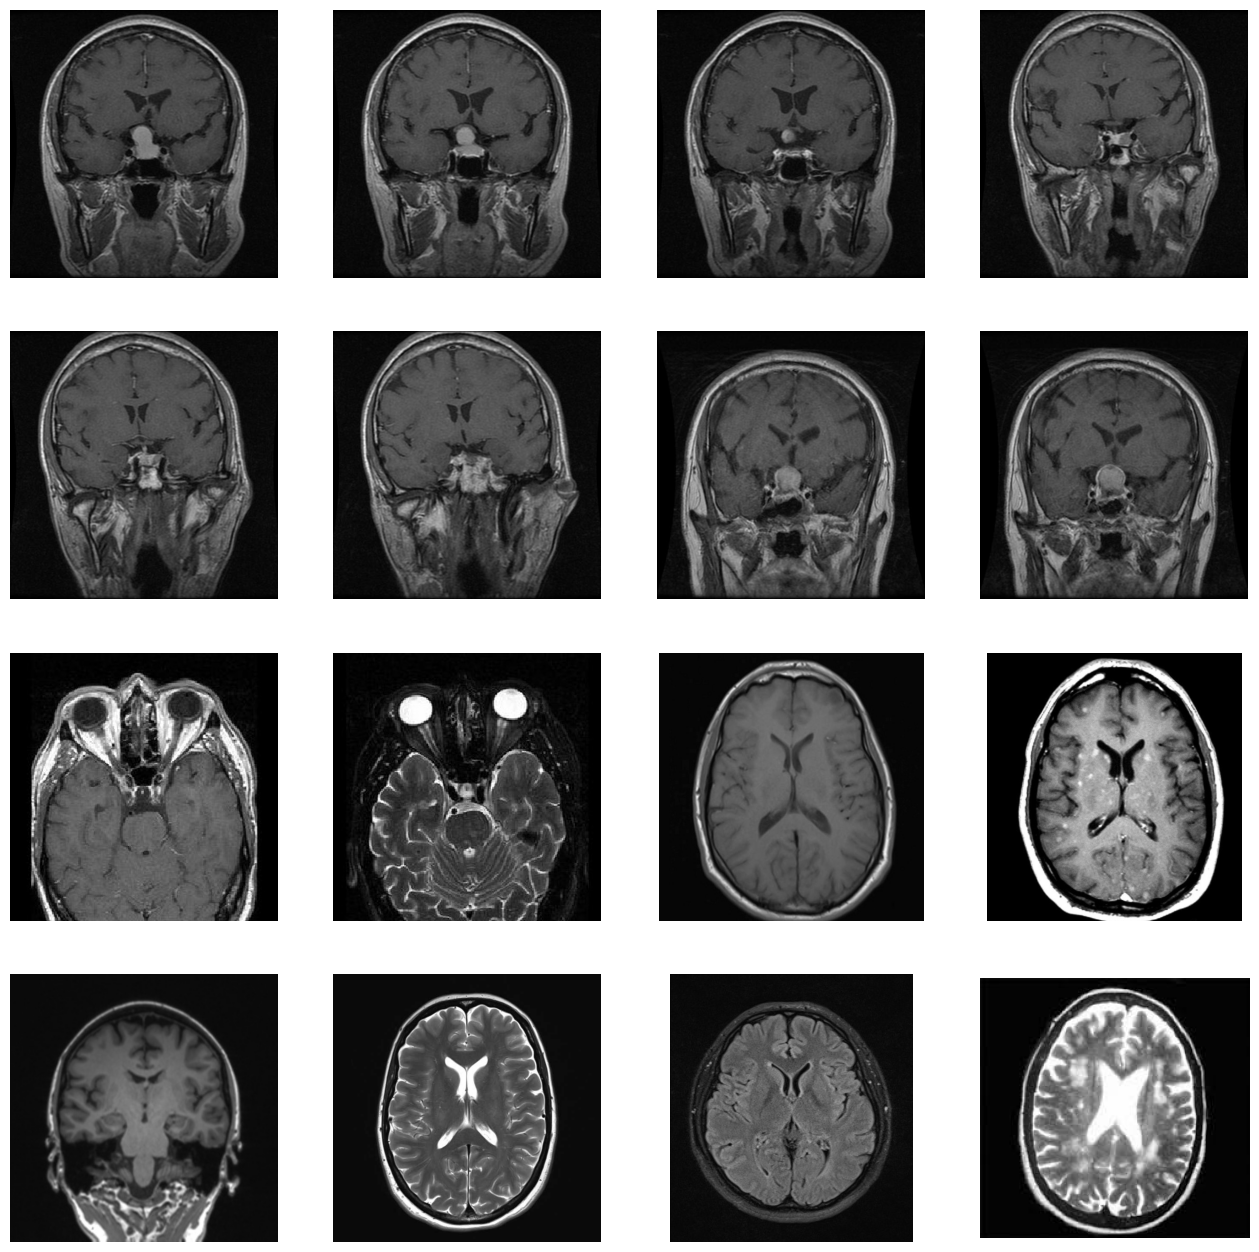

In [15]:
train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(pituitary_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

The images in the dataset exhibit considerable variation in dimensions, which presents a challenge for most Convolutional Neural Network (CNN) architectures. Pre-trained models used in **Transfer Learning typically require input images of consistent size**. To resolve this, the images will be centrally cropped to a uniform dimension. This resizing is seamlessly integrated into the data augmentation pipeline, as illustrated below.

## **Data Augmentation**

In many real-world scenarios, collecting a large volume of labeled images for training Convolutional Neural Networks (CNNs) can be challenging. To mitigate this limitation, data augmentation can be employed as an effective strategy. CNNs exhibit **translational invariance**, meaning they can recognize objects even when their position or orientation varies within an image. Leveraging this property, we can apply various augmentation techniques to artificially expand the training dataset, as outlined below:

**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember ***not to use data augmentation in the validation/test data set***.

As noted earlier, it is essential for all input images to have uniform dimensions. To ensure this, we specify the target_size parameter to resize all images to 224 × 224 pixels. This size is selected because the VGG16 model, which we use for Transfer Learning, requires input images of this dimension.

Since this is a binary classification task, we also need to assign class labels to the images. This is handled automatically by the flow_from_directory function in Keras. It loads images from the specified directory and assigns labels based on the subfolder names, with each folder representing a distinct class.

In this case, the train directory contains two subfolders: pituitary_tumor and no_tumor. The function interprets these as two separate classes. We set class_mode='binary' to indicate a binary classification problem. Additionally, the subfolders are read in alphabetical order by default, meaning no_tumor is assigned the label 0, and pituitary_tumor is assigned the label 1.

In [20]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     

# Flowing testing images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 830 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


To better understand the impact of data augmentation, we examine a few examples of the augmented training data.
This visualization helps illustrate how the original images are being transformed before training, and provides a useful point of comparison against the unaltered, raw input data..

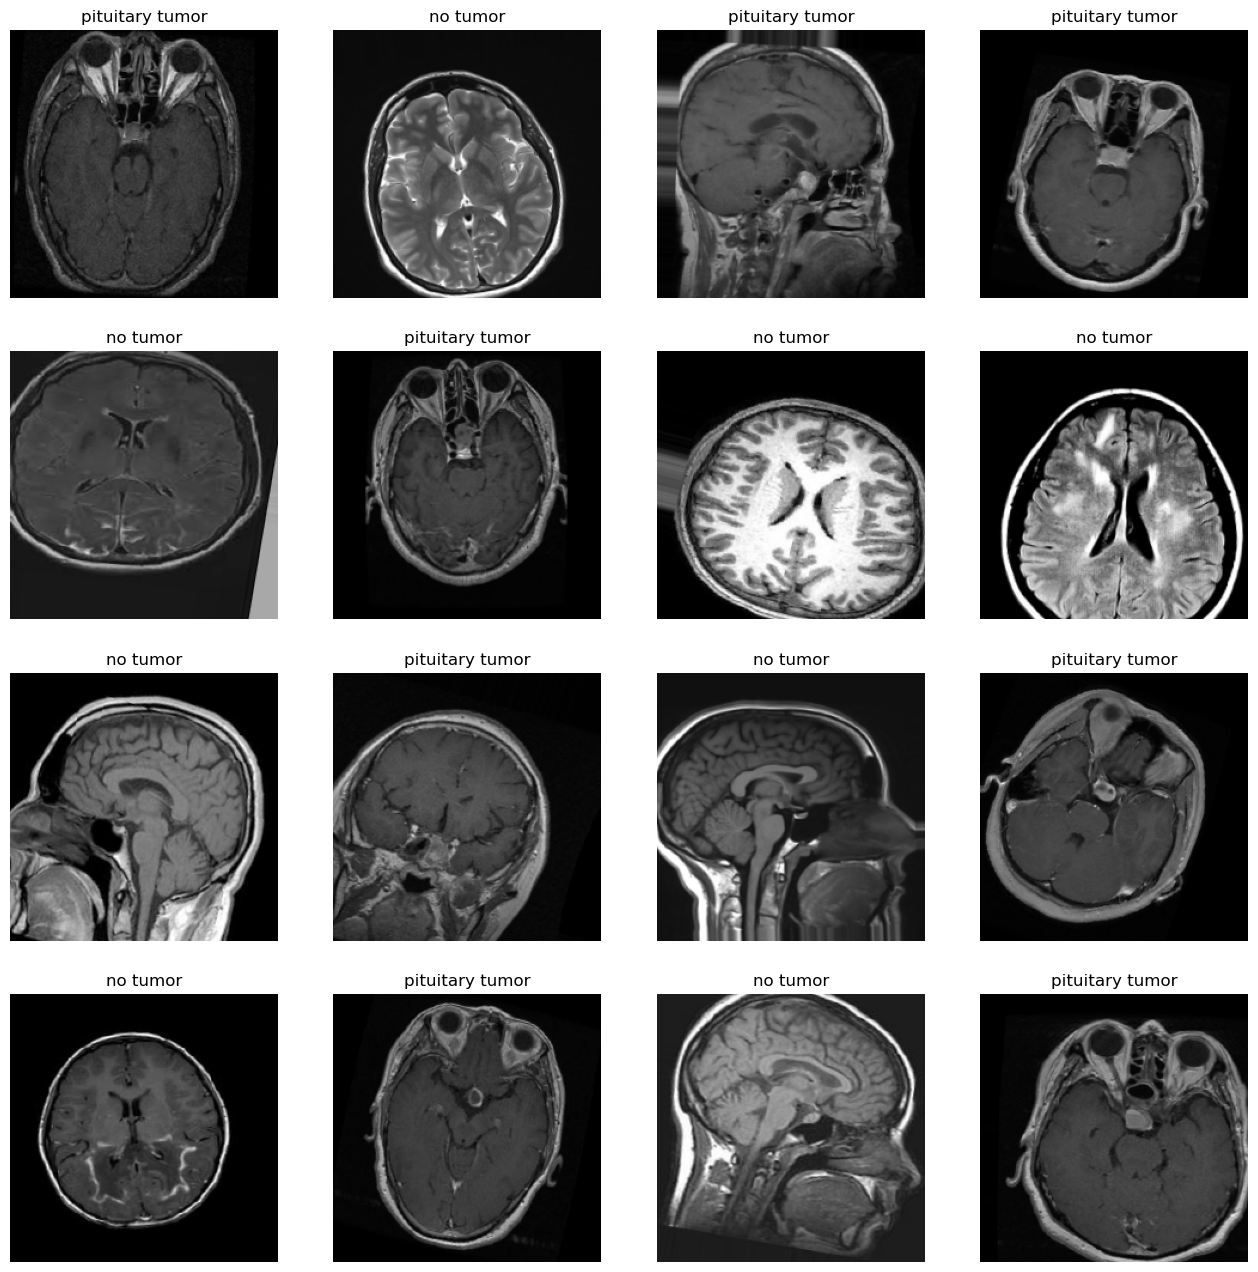

In [22]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1: 
        ax.set_title('pituitary tumor')
    else:
        ax.set_title('no tumor')
    ax.axis('off')

## **CNN Model Building**

After applying data augmentation and resizing the images to a uniform dimension, we proceed to develop an initial baseline Convolutional Neural Network (CNN) model to classify between the no_tumor and pituitary_tumor categories.
In designing this custom model, Batch Normalization and Dropout layers have been incorporated as regularization techniques to reduce the risk of overfitting and improve generalization performance.

In [25]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [26]:
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,561 (3.21 MB)

 Trainable params: 840,369 (3.21 MB)

 Non-trainable params: 192 (768.00 B)

In [27]:
# Option A: use built-in next()
testX, testY = next(validation_generator)


In [28]:
model_history = cnn_model.fit(train_generator, 
                              validation_data=(testX, testY),
                              epochs=10)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6395 - loss: 0.6257 - val_accuracy: 0.7000 - val_loss: 0.6261
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8365 - loss: 0.4054 - val_accuracy: 0.6000 - val_loss: 0.6707
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8627 - loss: 0.3653 - val_accuracy: 0.6000 - val_loss: 0.7218
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8671 - loss: 0.3461 - val_accuracy: 0.6000 - val_loss: 0.6747
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8863 - loss: 0.2710 - val_accuracy: 0.6000 - val_loss: 0.7537
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9103 - loss: 0.2059 - val_accuracy: 0.7500 - val_loss: 0.9974
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9400 - loss: 0.1765 - val_accuracy: 0.5000 - val_loss: 1.1744
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9264 - loss: 0.2196 - val_accuracy: 0.5000 - val_loss:

In [29]:
# Evaluating on the Test dataset
cnn_model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.6227 - loss: 0.8265


[0.779455304145813, 0.6352941393852234]

### **Findings**

- The baseline CNN model comprised approximately 840,369 trainable parameters.
- After training for 10 epochs, the model achieved a training accuracy of approximately 95%, while the validation accuracy plateaued around 72%.
- Despite the application of data augmentation, batch normalization, and dropout for regularization, the model exhibits signs of overfitting, suggesting that it has learned to perform well on the training data but generalizes poorly to unseen data.

## **Model Building using Transfer Learning: VGG 16**

- Now, let’s give it another try — this time applying the concept of Transfer Learning. We’ll use a pre-trained model architecture, VGG16, which was trained on the **ImageNet** dataset and secured second place in the 2014 ImageNet competition. A schematic of the **VGG16** model is shown below.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


![vgg16](https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png)

In [34]:
# Summary of the whole model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [36]:
vgg_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

- To remove the fully-connected layers of the imported pre-trained model, while calling it from Keras we can also specify an additonal keyword argument that is **include_top**. 

- **If we specify include_top = False, then the model will be imported without the fully-connected layers.** Here we won't have to do the above steps of getting the last convolutional layer and creating a separate model.

- If we are specifying include_top = False, we will also have to specify our input image shape.

- Keras has this keyword argument as generally while importing a pre-trained CNN model, we don't require the fully-connected layers and we train our own fully-connected layers for our task.

In [38]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [40]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [41]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [42]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,625 (59.20 MB)

 Trainable params: 803,937 (3.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator, 
                                  validation_data=(testX, testY),
                                  epochs=5)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.6822 - loss: 0.6471 - val_accuracy: 0.7000 - val_loss: 0.4428
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.9360 - loss: 0.2046 - val_accuracy: 0.7500 - val_loss: 0.4829
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.9760 - loss: 0.0944 - val_accuracy: 0.7500 - val_loss: 0.4625
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.9834 - loss: 0.0675 - val_accuracy: 0.7500 - val_loss: 0.4500
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.9813 - loss: 0.0584 - val_accuracy: 0.8000 - val_loss: 0.3912


In [44]:
# Evaluating on the Test set
new_model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8670 - loss: 0.2606


[0.2664414942264557, 0.8588235378265381]

In [45]:
# Function to plot loss, val_loss, 
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

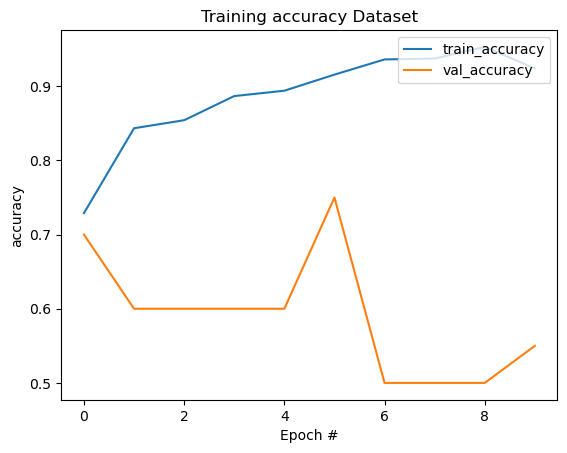

In [46]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history(model_history)

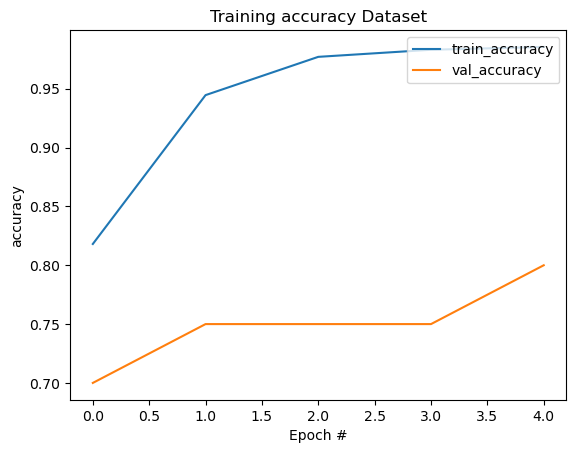

In [47]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

### Findings

- Our model contains 803,937 trainable parameters.

- After training for 5 epochs, we achieved a training accuracy of approximately 98% and a validation accuracy of around 91%.

## **Conclusions**

- The difference between the two models is clear. Although both had a similar number of trainable parameters, the custom CNN model, even after 10 epochs of training, was unable to match the accuracy levels achieved through Transfer Learning.

- The Transfer Learning model demonstrated faster convergence, reaching high performance within just 5 epochs.

- This represents a significant improvement achieved simply by leveraging a pre-trained architecture like VGG16.

- Additionally, with further fine-tuning, this model holds potential to reach accuracy levels suitable for practical use in medical applications.